In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import pandas_profiling as ppf
import warnings##忽略警告
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

import os
import sys
# os.chdir设置之后，os.path也会变为该路径
os.chdir(r"E:\soft\Anaconda\Anaconda_Python3.6_code\data_analysis\100_Data_analysis_competition\1_kaggle\9_Predict Future Sales\data")

# print(sys.path)
BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))))
print(BASE_DIR)
sys.path.insert(0, os.path.join(BASE_DIR, "101_Sklearn\\7_SVM"))
print(sys.path)

import FeatureTools as ft

import gc#垃圾回收机制
import time
import pickle#数据保存为一个pkl格式
from tqdm import tqdm
from itertools import product
from xgboost import XGBRegressor
from sklearn import preprocessing 
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

E:\soft\Anaconda\Anaconda_Python3.6_code\data_analysis
['E:\\soft\\Anaconda\\Anaconda_Python3.6_code\\data_analysis\\101_Sklearn\\7_SVM', 'e:\\soft\\anaconda\\anaconda_python3.6\\python36.zip', 'e:\\soft\\anaconda\\anaconda_python3.6\\DLLs', 'e:\\soft\\anaconda\\anaconda_python3.6\\lib', 'e:\\soft\\anaconda\\anaconda_python3.6', '', 'e:\\soft\\anaconda\\anaconda_python3.6\\lib\\site-packages', 'e:\\soft\\anaconda\\anaconda_python3.6\\lib\\site-packages\\pip-19.1-py3.6.egg', 'e:\\soft\\anaconda\\anaconda_python3.6\\lib\\site-packages\\win32', 'e:\\soft\\anaconda\\anaconda_python3.6\\lib\\site-packages\\win32\\lib', 'e:\\soft\\anaconda\\anaconda_python3.6\\lib\\site-packages\\Pythonwin', 'e:\\soft\\anaconda\\anaconda_python3.6\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\dell\\.ipython']


In [2]:
train = ft.readFile_inputData('sales_train.csv')
print(train.shape)
test = ft.readFile_inputData('test.csv')
print(test.shape)
shops = ft.readFile_inputData('shops.csv')
print(shops.shape)
items = ft.readFile_inputData('items.csv')
print(items.shape)
cats = ft.readFile_inputData('item_categories.csv')
print(cats.shape)

(2935849, 6)
(214200, 3)
(60, 2)
(22170, 3)
(84, 2)



 mu = 1.24 and sigma = 2.62

nan


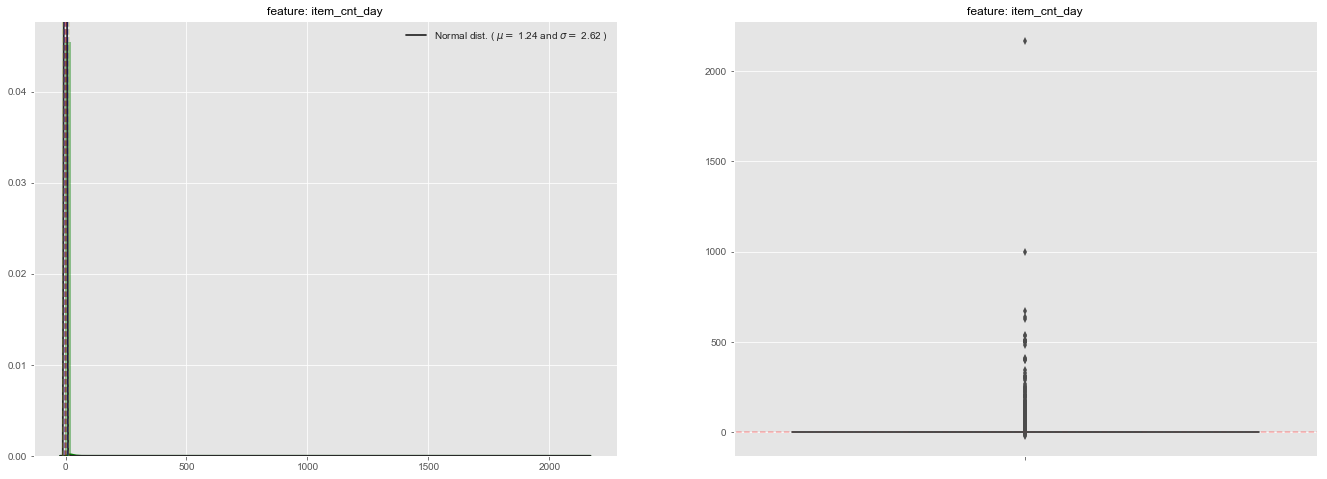

In [3]:
f, axes = plt.subplots(1,2, figsize=(23, 8))
ft.con_data_distribution(train, "item_cnt_day", axes)


 mu = 890.85 and sigma = 1729.80

0.13333333333333333


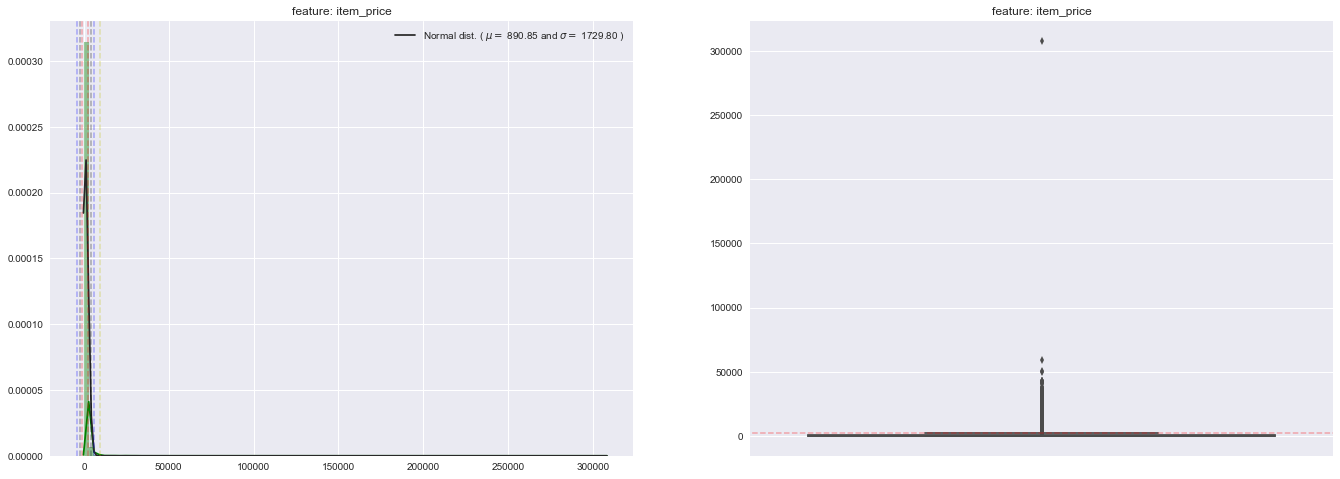

In [4]:
f, axes = plt.subplots(1,2, figsize=(23, 8))
ft.con_data_distribution(train, "item_price", axes)

In [5]:
# 数据可视化探索后进行数据的异常值删除
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1000]

In [6]:
# 数据填充
median = train[(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, "item_price"] = median

In [7]:
# 删除重复行
ft.duplicate_value(train, ["date","date_block_num","shop_id","item_id","item_price","item_cnt_day"], inplace=True)

去除重复项后长度：2935840(按行统计)
去除重复项后长度：2935840(按行统计)
重复项长度：6(按行统计)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935840 entries, 0 to 2935839
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None


In [8]:
# 数据集中的train和test数据集保持一致性
temp = test["shop_id"].unique()
print(type(temp))
print(np.sort(temp, axis=0))

##有几家商店是彼此的复制品,改变训练集和测试集将其更改为同一商店编号（不知为何它要这样改，意义何在？）
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

#清除训练集中在测试集中不存在的商店并且将数据集重做
train = train.merge(test[['shop_id']].drop_duplicates(), how = 'inner')

<class 'numpy.ndarray'>
[ 2  3  4  5  6  7 10 12 14 15 16 18 19 21 22 24 25 26 28 31 34 35 36 37
 38 39 41 42 44 45 46 47 48 49 50 52 53 55 56 57 58 59]


In [9]:
# 针对于shops数据
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [10]:
# 分解出商店所在城市
# 这种直接是看不懂，装X了
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0]) # 分开
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['shop_city'] = LabelEncoder().fit_transform(shops['city']) # 普通标签编码

#分解出商店名称
shops['name1'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
shops['shop_name1'] = LabelEncoder().fit_transform(shops['name1']) # 普通标签编码

#分解出商店经营类型
shops['type'] = shops['name1'].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' 
                                               if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'NO_DATA')
shops["shop_type"] = shops["type"].map({'NO_DATA': 0 ,'мтрц': 1 ,'тк': 2 ,'трк': 3 ,'трц': 4 ,'тц': 5 })

#更新数据shop数据
shops = shops[['shop_id','shop_city','shop_name1','shop_type']]
shops.head()

,shop_id,shop_city,shop_name1,shop_type
0,0,29,56,0
1,1,29,58,5
2,2,0,0,5
3,3,1,1,3
4,4,2,2,5


In [11]:
# 针对于item_category_id数据
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [12]:
# 分解出商品名
cats['split'] = cats['item_category_name'].str.split('-')

# 分解出商品的类型
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['item_type'] = LabelEncoder().fit_transform(cats['type'])

# 分解出商品的子类型
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['item_subtype'] = LabelEncoder().fit_transform(cats['subtype'])

# 更新数据
cats = cats[['item_category_id','item_type','item_subtype']]
cats.head()

,item_category_id,item_type,item_subtype
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [13]:
# 针对于item数据
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [14]:
items["item_name"].unique()

array(['! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D',
       '!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]',
       '***В ЛУЧАХ СЛАВЫ   (UNV)                    D', ...,
       'Язык запросов 1С:Предприятия 8 (+CD). Хрусталева Е.Ю.',
       'Яйцо для Little Inu', 'Яйцо дракона (Игра престолов)'],
      dtype=object)

In [15]:
# 分解
items['name_s1'], items['name_s2'] = items['item_name'].str.split('[', 1).str##分割成两个
items['name_s1'], items['name_s3'] = items['item_name'].str.split('(', 1).str##
items['name_s2'] = items['name_s2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()#所有大写的均变成小写
items['name_s3'] = items['name_s3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items = items.fillna('0')#空值用“0”来填充
items['name_1'] = LabelEncoder().fit_transform(items['name_s1'])
items['name_2'] = LabelEncoder().fit_transform(items['name_s2'])
items['name_3'] = LabelEncoder().fit_transform(items['name_s3'])
# 更新数据items
items = items[['item_id','item_category_id','name_1','name_2','name_3']]
items.head()

,item_id,item_category_id,name_1,name_2,name_3
0,0,40,0,4,1331
1,1,76,1,64,42
2,2,40,2,4,1011
3,3,40,3,4,1010
4,4,40,4,4,1572


In [21]:
# 特征重做--特征添加--目的就是做出item_cnt_month
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


In [ ]:
# 对于每个月，我们从该月的所有商店/产品的而唯一标识符组合创建一个网格
matrix = [] # 空列表
cols = ['date_block_num','shop_id','item_id']#训练集里面的特征
for i in train['date_block_num'].unique(): # 找出每一个,只相当于对每一个进行后续操作,减少运算的意思
    sales = train[train.date_block_num==i] # 取出来相当于前提条件
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16')) # 进行添加到列表里面
matrix = pd.DataFrame(np.vstack(matrix), columns=cols) # 做成df的格式
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8) # 转换数据类型
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True) # 进行排序

# 求每月该商品的售出量:item_cnt_month
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']}) # groupby的作用，相当于一个月卖出的东西
group.columns = ['item_cnt_month']
group.reset_index(inplace=True) # 重置索引

matrix = pd.merge(matrix, group, on=cols, how='left') # 进行组合
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))#把这一列空值进行填充和进行范围限制

# 要使用时间技巧，将测试集和matrix进行组合
test['date_block_num'] = 34
matrix = pd.concat([matrix, test], ignore_index=True, keys=cols)##数据进行组合
matrix.fillna(0, inplace=True) # 34 month
# del test # 删除test
gc.collect() # 垃圾回收机制

In [23]:
# 分解1
matrix = [] # 空列表
cols = ['date_block_num','shop_id','item_id']#训练集里面的特征
sales = train[train.date_block_num==0]
matrix.append(np.array(list(product([0], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
sales = train[train.date_block_num==1]
matrix.append(np.array(list(product([1], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
print(matrix)
print(np.vstack(matrix))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols) # 做成df的格式
print(matrix[0:3])
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)#转换数据类型
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)#进行排序

[array([[    0,    59, 22154],
       [    0,    59, 22151],
       [    0,    59,  5603],
       ...,
       [    0,    45, 12203],
       [    0,    45, 13912],
       [    0,    45, 14941]], dtype=int16), array([[    1,    59,  4906],
       [    1,    59,  4907],
       [    1,    59,  4909],
       ...,
       [    1,     5, 18891],
       [    1,     5, 20190],
       [    1,     5, 15061]], dtype=int16)]
[[    0    59 22154]
 [    0    59 22151]
 [    0    59  5603]
 ...
 [    1     5 18891]
 [    1     5 20190]
 [    1     5 15061]]
   date_block_num  shop_id  item_id
0               0       59    22154
1               0       59    22151
2               0       59     5603


In [24]:
# 分解2
# 求每月该商品的售出量:item_cnt_month
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})##groupby的作用，相当于一个月卖出的东西
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)#重置索引
group.head(3)

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0


In [25]:
# 分解3
matrix = pd.merge(matrix, group, on=cols, how='left') # 进行组合
# clip(x, y)：Align object with lower and upper along the given axis. 指定矩阵值范围在
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))#把这一列空值进行填充和进行范围限制
print(max(matrix['item_cnt_month']))
print(matrix.loc[0:3, 'item_cnt_month'])

20.0
0    0.0
1    1.0
2    0.0
3    0.0
Name: item_cnt_month, dtype: float16


In [26]:
# 分解4
unique_label, counts_label = np.unique(train['date_block_num'], return_counts=True)
print(unique_label)
print(counts_label)

print(test.shape)
print(test.head(3))

print(matrix.shape)
# 要使用时间技巧，将测试集和matrix进行组合
test['date_block_num'] = 34 # test的date_block_num设置为34
matrix = pd.concat([matrix, test], ignore_index=True, keys=cols) # 数据进行组合
matrix.fillna(0, inplace=True) # 34 month
print(matrix.shape)
print(matrix.head(3))

# del test # 删除test
gc.collect() # 垃圾回收机制

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
[ 88763  84878  94699  73941  73637  82848  81760  84737  77364  75133
  78346 116661  79695  73394  74902  63194  63152  66939  64118  71022
  59907  63118  70664 107872  72401  61828  60649  51603  50147  51177
  52736  56147  50019  51821]
(214200, 4)
   ID  shop_id  item_id  date_block_num
0   0        5     5037              34
1   1        5     5320              34
2   2        5     5233              34
(544551, 4)
(758751, 5)
    ID  date_block_num  item_cnt_month  item_id  shop_id
0  0.0               0             0.0       19        2
1  0.0               0             1.0       27        2
2  0.0               0             0.0       28        2


207

In [27]:
# 数据组合
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
print(matrix.shape) # 做好的一个数据
print(matrix.head(3))

del shops,items,cats
gc.collect()

(758751, 14)
    ID  date_block_num  item_cnt_month  item_id  shop_id  shop_city  \
0  0.0               0             0.0       19        2          0   
1  0.0               0             1.0       27        2          0   
2  0.0               0             0.0       28        2          0   

   shop_name1  shop_type  item_category_id  name_1  name_2  name_3  item_type  \
0           0          5                40      19       4      42         11   
1           0          5                19      27      77      42          5   
2           0          5                30      28     108      42          8   

   item_subtype  
0             4  
1            10  
2            55  


167

In [50]:
# 定义滞后特征函数相当于将df里的滞后
def lag_feature(df, lags, col):
    print(id(df))
    tmp = df[['date_block_num','shop_id','item_id',col]]
    print(id(tmp))
    for i in lags:
        shifted = tmp.copy()
        print(id(shifted))
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        print(id(shifted), shifted.columns)
        shifted['date_block_num'] += i##一个一个来
        print(id(shifted), shifted['date_block_num'][0])
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')#组合
        print(id(df))
        print("-"*30)
    return df

# 定义添加的特征
def tianjia1(list_names,list_num):
    global matrix#全局化
    str1 = list_names[0]
    for i in range(1,len(list_names)):
        str1 = str1+'_and_'+list_names[i]
    str1 = str1+'_avg_item_cnt'##连接符
    
    group = matrix.groupby(list_names).agg({'item_cnt_month': ['mean']})#相当于重做特征变成均值
    group.columns = [str1]
    group.reset_index(inplace=True)#重置索引
##每新增特征之后就要和原来的进行合并
    matrix = pd.merge(matrix, group, on=list_names, how='left')
    matrix[str1] = matrix[str1].astype(np.float16)##转换数据类类型
    matrix = lag_feature(matrix, list_num, str1)
    matrix.drop([str1], axis=1, inplace=True)##和并之后删除

In [52]:
matrix_new = lag_feature(matrix, [1,2,3], 'item_cnt_month')#将月销售量分别滞后1，2，3个月
matrix_new.head(3)

1992138017984
1990721297544
1990791189896
1990791189896 Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month_lag_1'], dtype='object')
1990791189896 1
1990721295024
------------------------------
1990721297432
1990721297432 Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month_lag_2'], dtype='object')
1990721297432 2
1992446017264
------------------------------
1990721295024
1990721295024 Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month_lag_3'], dtype='object')
1990721295024 3
1990721323920
------------------------------


,ID,date_block_num,item_cnt_month,item_id,shop_id,shop_city,shop_name1,shop_type,item_category_id,name_1,name_2,name_3,item_type,item_subtype,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0.0,0,0.0,19,2,0,0,5,40,19,4,42,11,4,NaN,NaN,NaN
1,0.0,0,1.0,27,2,0,0,5,19,27,77,42,5,10,NaN,NaN,NaN
2,0.0,0,0.0,28,2,0,0,5,30,28,108,42,8,55,NaN,NaN,NaN


In [ ]:
tianjia1(['date_block_num'],[1])#将每个月的销售量滞后1个月
tianjia1(['date_block_num', 'item_id'],[1,2,3])#将每个月的每个商品的平均销售量分别滞后1，2，3个月
tianjia1(['date_block_num', 'shop_id'],[1,2,3])#将每个月的每个商店的平均销售量分别滞后1，2，3个月
tianjia1(['date_block_num', 'shop_city'],[1])
tianjia1(['date_block_num', 'shop_name1'],[1])
tianjia1(['date_block_num', 'shop_type'],[1])
tianjia1(['date_block_num', 'item_category_id'],[1])
tianjia1(['date_block_num', 'item_type'],[1])
tianjia1(['date_block_num', 'item_subtype'],[1])
tianjia1(['date_block_num', 'shop_id', 'item_id'],[1])
tianjia1(['date_block_num', 'shop_id', 'name_1'],[1])
tianjia1(['date_block_num', 'shop_id', 'name_2'],[1])
tianjia1(['date_block_num', 'shop_id', 'name_3'],[1])
tianjia1(['date_block_num', 'shop_id', 'item_category_id'],[1])